## 적대적 샘플은 무엇인가?



적대적 샘플(Adversarial examples)은 원본 샘플에 약간의 노이즈를 추가하여 사람이 보기에는 원본 샘플과 유사하지만 뉴럴네트워크에 의해서 잘못 오인식 되는 샘플이다. 
FGSM 방법 중에 white box 공격으로 공격자는 모델에 대한 파라미터, classification score(logit 값) 등에 대한 모든 정보를 아는 환경에서 공격을 한다고 가정한다.

이 중 FGSM (fast gradient sing method)는 입력값에 대한 기울기 변화율을 이용하여 적대적 샘플을 생성하는 방법으로 가장 심플하지만 공격효과가 좋은 방법이다. 

![Adversarial Example](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/adversarial_example.png?raw=1)

이 그림에서, 판다 그림(원본샘플)이라고 할때, 공격자가 원본 샘플에 작은 노이즈(small perturbations or distortion) 추가하여 생성된 적대적 샘플은 타겟 뉴럴네트워크에 의해서 원숭이(giboon)으로 높은 확률로 분류하게 된다.

## Fast gradient sign method (FGSM)
FGSM 방법은 적대적 샘플을 생성시 입력 이미지에 대한 기울기값의 변화율을 이용한다. 
FGSM 생성하기 위한 알고리즘은 아래와 같다. 
$$x^{*} = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   $x^{*}$ : 적대적 샘플(Adversarial image). 아래 코드에서 $x^{*}$는 adv_x로 표기
*   x : 원본 샘플(Original input image).
*   y : 원본 클래스(Original input label).
*   $\epsilon$ : 입실론값으로 노이즈의 가중치 값(Multiplier to ensure the perturbations are small.)
*   $\theta$ : 뉴럴네트워크 모델의 파라미터(Model parameters).
*   $J$ : 손실함수 또는 목적함수(Loss).

입력 이미지에 대한 기울기값(gradient)을 계산을 통해서 적대적 샘플을 생성한다. 
손실함수(loss) 값을 극대화하여 뉴럴네트워크의 오안식을 일으키는 방법이다. 손실함수를 극대화 하기 위해서, 입력 이미지에서 각 픽셀에서 어떤 픽셀이 손실함수를 극대화하는 노이즈(perturbation or noise)가 생성이 된다. 
이러한 기울기값(경사하강법)을 계산하기 위해서, 채인룰(chain rule) 방식이 적용된다.

적대적 샘플은 학습하는 과정 상 입력 이미지에 대한 변화를 통해서 오인식을 일어나는 방법이고 이미 학습이 끝난 모델을 대상으로 한다. 따라서 모델의 파라미터는 고정된 값이고 입력 이미지에 오인식을 일으킬 수 있는 노이즈를 구하여 적대적 샘플을을 생성한다.

여기서서 뉴럴네트워크크 모델은은 MobileNetV2으로 ImageNet 학습데이터로 이미 학습된 모델이다

[MobileNetV2](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/MobileNetV2), [ImageNet](http://www.image-net.org/).

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

Let's load the pretrained MobileNetV2 model and the ImageNet class names.

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet 라벨 불러오기
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14548992/14536120 [==============================] - 0s 0us/step


In [ ]:
# MobieNetv2의 입력값 형태로 바꿔주기 위한 전처리 절차
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# probs (확률벡터)로 부터 라벨 (가장 높은 확률에 해당되는 클래스)로 추출하는 함수
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Original image
Let's use a sample image of a [Labrador Retriever](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg) by Mirko [CC-BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/) from Wikimedia Common and create adversarial examples from it. The first step is to preprocess it so that it can be fed as an input to the MobileNetV2 model.

In [ ]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

98304/83281 [===================================] - 0s 0us/step


Let's have a look at the image.

49152/35363 [=========================================] - 0s 0us/step


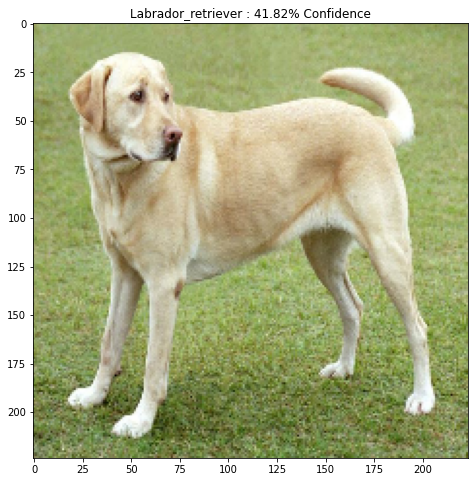

In [ ]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # image[0] shape를 [-1, 1]에서 [0,1]으로 변경하기
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the adversarial image

### Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

In [39]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # 입력 이미지 (input_image) 에 대한 손실함수의 기울기값을 구함
  gradient = tape.gradient(loss, input_image)
  # 기울기값에 대한 sign을 적용하여 perturbation을 계산함. 아래 설명 참고해보기. 
  signed_grad = tf.sign(gradient)
  return signed_grad

The resulting perturbations can also be visualised.

Sign function에 대한 이해 필요.
tf.sign에 대한 설명 참고하기. \\
ex. $y = sign(x) = x / |x|$ if $x != 0$, otherwise $y = 0$
 ![tf.sign](https://github.com/c15926/AI-Security/blob/main/FGSM-tf.sign.png?raw=1)

> Indented block



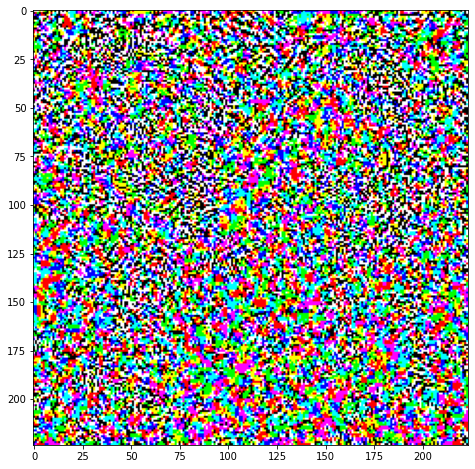

In [ ]:
# 이미지의 입력 라벨(클래스) 추출하는 과정
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [ ]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

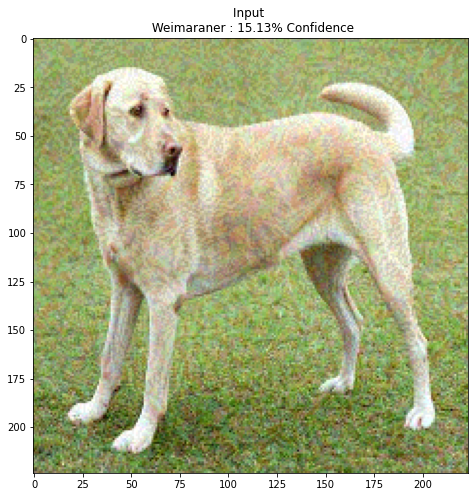

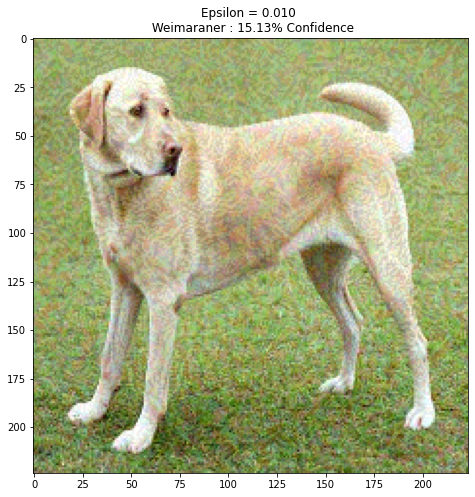

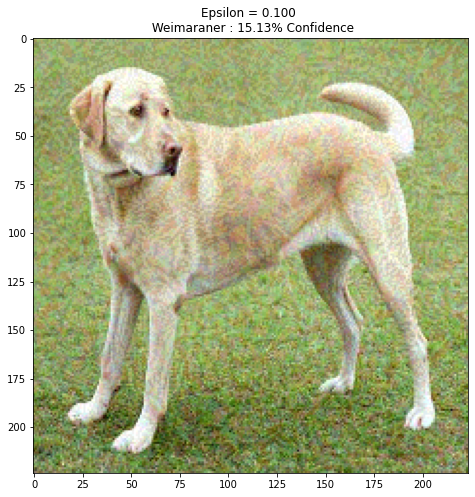

In [ ]:
epsilons = [0, 0.01, 0.1]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  ### Quiz 아래 코드를 넣으시오.###
  
  #############
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

22403.912
11243221.0
0.15000004


# FGSM 예상 문제 
1. (실습) 적대적샘플($x^{x}$ or adv) 계산식 코드 작성하기 (퀴즈와 연관) \\
2. (이론) 적대적샘플($x^{x}$ or adv) 수식 또는 구하는 값 - 이론으로 풀기
3. (실습) FGSM 적대적 샘플 생성 시 gradient를 sign 적용하는 방법 (코드 넣기) \\
4. (이론) FGSM 적대적 샘플 생성 시 gradient 값을 행렬로 제시할 경우 -> sign으로 어떻게 변환되는지 풀기


[CleverHans](https://github.com/tensorflow/cleverhans) - 다양한한 적대적적 샘플을을 생성한